In [1]:
import mlflow
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge 

from pickle import dump

from hyperopt import fmin, tpe, Trials, STATUS_OK, hp, space_eval
from functools import partial

from scripts.Preprocessing import Preprocessing
from scripts.LinearRegressionTraining import LinearRegressionTraining
from scripts.config import (year_month_train, 
    input_data_path_train,
    seed)

### MLFlow setting

In [2]:
local_path_save = './local_artifacts_tmp/02_1_Ridge_Regression/'
year_month = year_month_train
input_data_path = input_data_path_train

In [3]:
if not os.path.exists(local_path_save):
    os.makedirs(local_path_save)

#save all metadata in a sqlite db. Artifacts will be saved on local folder ./mlflow    
mlflow.set_tracking_uri("sqlite:///mlflow.db")

# Name of the experiment
exp_name = "02.1 - Regularized Linear Regression - Ridge"
# set up MlFlow axperiment
experiment_id = mlflow.set_experiment(exp_name)

2023/01/17 17:00:15 INFO mlflow.tracking.fluent: Experiment with name '02.1 - Regularized Linear Regression - Ridge' does not exist. Creating a new experiment.


## Experiments

In [4]:
run_name = 'base'

In [5]:
ridge_regression_training = LinearRegressionTraining(
    input_data_path,
    local_path_save,
    year_month,
    'ridge')

In [6]:
max_evals = 5

# Here we can decide which hyperparameters we want to tune
# For the Ridge regression, alpha tunes the amount of regularization
# Alpha = 0 means no regularization == Linear Regression
ridge_parameters_search = {
    'alpha': hp.lognormal('alpha', 0, 1),
    'random_state': seed
}

ridge_regression_training.set_hyperparameter_space(ridge_parameters_search)

In [7]:
#### Data Preprocessing ####

prepr = Preprocessing(input_data_path_train)
X, Y = prepr.read_dataframe(request_tgt=True)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

#preprocessing ohe
shapes_pre = (X_train.shape[0], X_test.shape[0])
X_train_ohe, ohe = prepr.preprocess_for_regression(df=X_train, fit_ohe=True)
X_test_ohe, _ = prepr.preprocess_for_regression(df=X_test, fit_ohe=False, ohe=ohe)
assert shapes_pre == (X_train.shape[0], X_test.shape[0])
dump(ohe, open(local_path_save + run_name + '_ohe.pkl', 'wb'))

/Users/davideposillipo/Documents/Didattica.nosync/DSR_ML_Fundamentals_2023/scripts/Preprocessing.py:83: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['lpep_pickup_datetime_week'] = df['lpep_pickup_datetime'].dt.week
/Users/davideposillipo/Documents/Didattica.nosync/DSR_ML_Fundamentals_2023/scripts/Preprocessing.py:83: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['lpep_pickup_datetime_week'] = df['lpep_pickup_datetime'].dt.week


In [8]:
# Calculating regression baseline
ridge_regression_training.calculate_regression_baseline(Y_train=Y_train, Y_test=Y_test, run_name=run_name)

{'loss': 7.211841215227615, 'status': 'ok'}

In [9]:
trials = Trials()

best_result = fmin(
    fn=partial(ridge_regression_training.objective_lr_ridge, 
        X_train=X_train_ohe,
        X_test=X_test_ohe,
        Y_train=Y_train,
        Y_test=Y_test,
        run_name=run_name),
    space=ridge_parameters_search,
    algo=tpe.suggest,
    max_evals=max_evals,
    trials=trials,
    rstate=np.random.default_rng(seed)
)

best_result

 20%|███████████████████▊                                                                               | 1/5 [00:02<00:11,  2.92s/trial, best loss: 5.184406405699592]

/Users/davideposillipo/.pyenv/versions/3.10.9/envs/prova/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.74s/trial, best loss: 5.181029228191513]


{'alpha': 0.937656619933378}

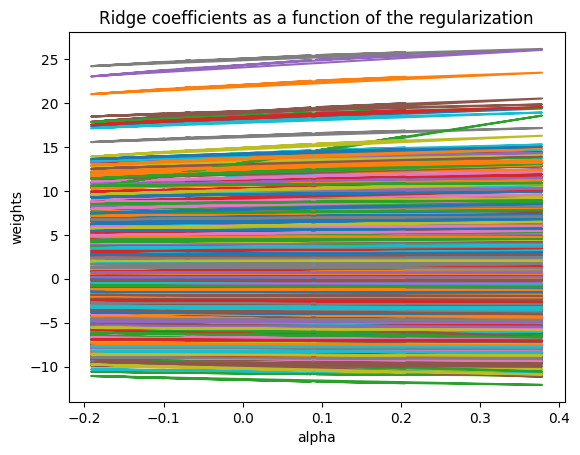

In [10]:
import matplotlib.pyplot as plt

n_alphas = 10
alphas = np.random.lognormal(0, 0.5, n_alphas)

coefs = []
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_ohe, Y_train)
    coefs.append(ridge.coef_)
    
ax = plt.gca()

neg_log_alphas_ridge = -np.log10(alphas)

ax.plot(neg_log_alphas_ridge, coefs)
#ax.set_xlim(ax.get_xlim()[::-1])
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()